```
Copyright 2021 Twitter, Inc.
SPDX-License-Identifier: Apache-2.0
```

## Image Crop Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twitter-research/image-crop-analysis/blob/master/notebooks/Image%20Crop%20Analysis.ipynb)

In [1]:
import logging
import shlex
import subprocess
import sys
from collections import namedtuple
from pathlib import Path

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

logging.basicConfig(level=logging.ERROR)

In [2]:
import platform

BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

HOME_DIR = Path("../").expanduser()

try:
    import google.colab
    ! pip install pandas scikit-learn scikit-image statsmodels requests dash
    ! [[ -d image-crop-analysis ]] || git clone https://github.com/twitter-research/image-crop-analysis.git
    HOME_DIR = Path("./image-crop-analysis").expanduser()
    IN_COLAB = True
except:
    IN_COLAB = False

sys.path.append(str(HOME_DIR / "src"))
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"
data_dir = HOME_DIR / Path("./data/")
data_dir.exists()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0
Cloning into 'image-crop-analysis'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 72 (delta 17), reused 14 (delta 14), pack-reused 47 (from 1)
Receiving objects: 100% (72/72), 3.32 MiB | 13.19 MiB/s, done.
Resolving deltas: 100% (25/25), done.


True

In [ ]:
img_path = next(data_dir.glob("./*.jpeg"))
img_path

In [ ]:
img = mpimg.imread(img_path)
plt.imshow(img)
plt.gca().add_patch(
    Rectangle((0, 0), 200, 112, linewidth=1, edgecolor="r", facecolor="none")
)

In [ ]:
str(img_path.absolute())

In [ ]:
cmd = f"{str(bin_path)} {str(model_path)} '{img_path.absolute()}' show_all_points"
cmd

In [ ]:
output = subprocess.check_output(cmd, shell=True)  # Success!
print(output.splitlines())

In [ ]:
! {str(bin_path)} {str(model_path)} '{img_path.absolute()}' show_all_points | head

In [14]:
from crop_api import ImageSaliencyModel, is_symmetric, parse_output, reservoir_sampling

In [15]:
parse_output(output).keys()

NameError: name 'output' is not defined

In [16]:
model = ImageSaliencyModel(crop_binary_path=bin_path, crop_model_path=model_path)

In [ ]:
plt.matplotlib.__version__

In [ ]:
list(data_dir.glob("./*.jpeg"))

In [ ]:
for img_path in data_dir.glob("*.jpeg"):
    print(img_path)
    model.plot_img_crops(img_path)

In [ ]:
for img_path in data_dir.glob("*.jpeg"):
    print(img_path)
    model.plot_img_crops(img_path)

In [ ]:
for img_path in reservoir_sampling(data_dir.glob("./*.jpeg"), K=5):
    model.plot_img_crops(img_path)

In [ ]:
model.plot_img_crops(data_dir / Path("./dummy.jpeg"), topK=2)
plt.savefig("dummy.jpg", bbox_inches="tight")

## Sample crops based on saliency scores


* First, we show the top 3 crops based sorted saliency scores (highest first)
* Next, we show the top 3 crops sampled based on saliency scores converted into probs using the following formula:

$$
\begin{equation}
p_i = \frac{exp(s_i)}{Z}\\
Z = \sum_{j=0}^{j=N} exp(s_j)
\end{equation}
$$

In [ ]:
model.plot_img_crops(data_dir / Path("./dummy.jpeg"), topK=3)
plt.savefig("dummy_top3.jpeg", bbox_inches="tight")

In [ ]:
model.plot_img_crops(data_dir / Path("./dummy.jpeg"), topK=3, sample=True)

## Crop an image generated using combination of images

In [7]:
from PIL import Image

#from image_manipulation import join_images

In [8]:
images = [Image.open(x) for x in data_dir.glob("./*.jpeg")]
img = join_images(images, col_wrap=2, img_size=(128, -1))

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

In [ ]:
img

In [9]:
images = [
    Image.open(data_dir / Path("/content/Man_WC__0.1420.jpeg")),
    Image.open(data_dir / Path("/content/Man_WC__0.4094.jpeg")),
]
img = join_images(images, col_wrap=2, img_size=(128, 128), padding=0)
model.plot_img_crops_using_img(img, topK=5)
plt.savefig("dummy_dummy.jpeg", bbox_inches="tight")

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

In [ ]:
images = [
    Image.open(data_dir / Path("./dummy.jpeg")),
    Image.open(data_dir / Path("./dummy.jpeg")),
]
img = join_images(images, col_wrap=1, img_size=(128, 128), padding=100)
model.plot_img_crops_using_img(img, topK=1)

In [ ]:
img

In [12]:
from PIL import Image

def combine_images(image_path1, image_path2, output_path):
    img1 = Image.open(image_path1).convert("RGB")
    img2 = Image.open(image_path2).convert("RGB")

    # Resize to same height
    h = min(img1.height, img2.height)
    img1 = img1.resize((int(img1.width * h / img1.height), h))
    img2 = img2.resize((int(img2.width * h / img2.height), h))

    # Combine horizontally
    new_img = Image.new("RGB", (img1.width + img2.width, h))
    new_img.paste(img1, (0, 0))
    new_img.paste(img2, (img1.width, 0))
    new_img.save(output_path)

# Example
combine_images("/content/Man_WC__0.1420.jpeg", "/content/Man_WC__0.4094.jpeg", "combined_AB.jpg")


In [ ]:
img.save("dummy_dummy_stiched.jpeg", "JPEG")

None 748 503


AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

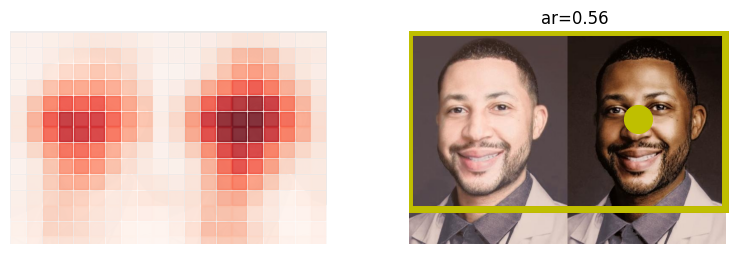

In [17]:
img_path = Path("/content/dummy_dummy_stiched.jpg")
model.plot_img_crops(img_path, topK=1)
plt.savefig("/content/dummy_dummy.jpg", bbox_inches="tight")

[0.56] 748 503


AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

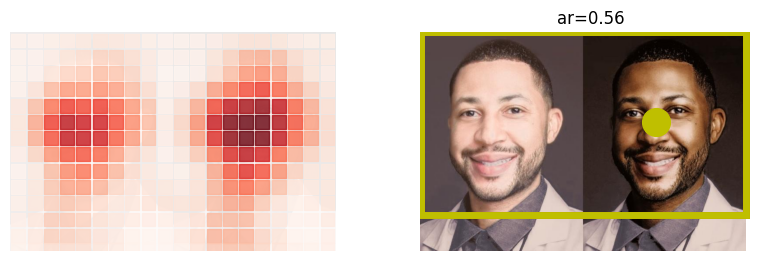

In [19]:
model.plot_img_crops(data_dir / Path("/content/dummy_dummy_stiched.jpg"), topK=2, aspectRatios=[0.56])
plt.savefig("dummy.jpeg", bbox_inches="tight")

None 748 503


AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

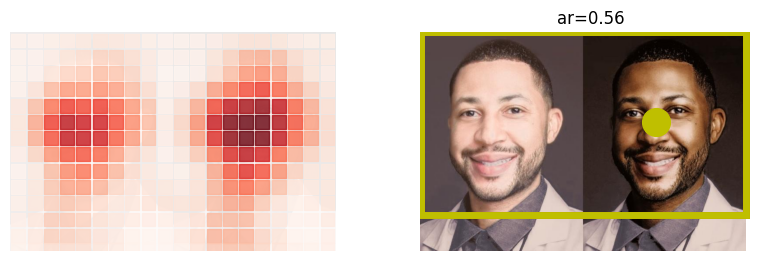

In [20]:
img_path = Path("/content/dummy_dummy_stiched.jpg")
model.plot_img_crops(img_path, topK=1, add_saliency_line=False, col_wrap=3)
plt.savefig("dummy_dummy.jpeg", bbox_inches="tight")